In [ ]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

from tpelm import *
from tpelm.bspline import BSpline
from tpelm.tensor_grid import TensorGrid
from tpelm.magnetostatic import DomainState, solve_energy, fit_mag

from sources import m_uniform, flower_state, vortex_state

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")

# Higher order stray field magnetostatic energy computation

In this notebook, the higher order stray field method is used for magnetostatic energy
computation. 

First we define the `setup` and the `solve` function. `setup` initializes a solver for the respective domain and computes factor matrices to solve the superpotential. The `solve` function computes the
magnetostatic energy. We use the same TPELM for superpotential and magnetization ($r_p=r_p'$) but note that for easy magnetizations (e.g. flower state) we could use a much smaller rank $r'$ which would speed up the computation drastically.

In [54]:
target_tg = TensorGrid(*[jnp.linspace(-0.5, 0.5, 2)] * 3).to_gauss(250)

@partial(jax.jit, static_argnames=("s"))
def setup(model, target_tg, mag_model=None, mag_quad_grid=None, s=46):
    state = DomainState.init(
        sp_elm=model,
        mag_elm=mag_model,
        sp_quad_grid=target_tg,
        mag_quad_grid=mag_quad_grid,
        target_quad_grid=target_tg,
        gs_terms=s,
        gk_epsabs=1e-13,
        gk_epsrel=0.0,
        gk_order=41,
        gk_max_ninter=50
    )
    return state

@jax.jit
def solve(state: DomainState, mag) -> jax.Array:
    return solve_energy(state, mag)


## Energy for a uniformly magnetized cube

We solve the energy for a uniform magnetization within the unit cube. Theoretically we could set $r'=1$ with $k'=0$ to perfectly fit the magnetization, but we use a much larger rank here for demonstration.

The energy is computed for different ranks $r$ and different B-spline orders $k$. The number of exponential sum terms $S=46$ is used. All fitting procedures use 250 Gauss-Legendre quadrature points for each dimension. This could also be done per spline segment instead to improve accuracy.

In [ ]:
energies_uniform = defaultdict(dict)

# uniform state
e_true = 1 / 6
ks = [3, 4, 5, 6, 7, 8]
rs = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

for k in ks:
    for r in rs:
        mag_grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, 2)] * 3)
        mag_model = BSpline(mag_grid, degree=0)
        grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, r)] * 3)
        model = BSpline(grid, degree=k - 1)
        solver, mag = setup(model, target_tg, mag_model=mag_model, mag_quad_grid=mag_grid.to_gauss(1), s=80)
        mag = fit_mag(solver, m_uniform)  # prefit magnetization to functional Tucker format
        e = solve(solver, mag).block_until_ready()
        energies_uniform[k][r] = e
        err = jnp.abs(e - e_true)
        t = %timeit -q -o -n 5 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, error={err:.4e}, fitting_time={t.average * 1000:.3f} ms")

k=3, r=5, energy=9.170869e-02, error=7.4958e-02, fitting_time=2.567 ms
k=3, r=10, energy=1.132705e-01, error=5.3396e-02, fitting_time=2.714 ms
k=3, r=15, energy=1.177204e-01, error=4.8946e-02, fitting_time=2.878 ms
k=3, r=20, energy=1.201874e-01, error=4.6479e-02, fitting_time=3.467 ms
k=3, r=25, energy=1.219429e-01, error=4.4724e-02, fitting_time=4.149 ms
k=3, r=30, energy=1.229952e-01, error=4.3671e-02, fitting_time=5.273 ms
k=3, r=35, energy=1.234302e-01, error=4.3236e-02, fitting_time=7.653 ms
k=3, r=40, energy=1.249372e-01, error=4.1729e-02, fitting_time=7.012 ms
k=3, r=45, energy=1.246556e-01, error=4.2011e-02, fitting_time=8.939 ms
k=3, r=50, energy=1.267066e-01, error=3.9960e-02, fitting_time=10.634 ms
k=3, r=55, energy=1.254391e-01, error=4.1228e-02, fitting_time=21.143 ms
k=3, r=60, energy=1.251489e-01, error=4.1518e-02, fitting_time=16.192 ms
k=4, r=5, energy=1.499448e-01, error=1.6722e-02, fitting_time=2.651 ms
k=4, r=10, energy=1.620786e-01, error=4.5881e-03, fitting_time=

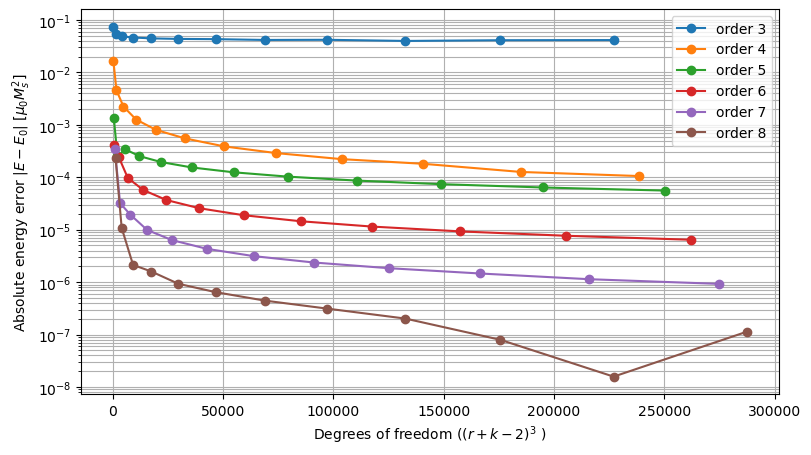

In [45]:
e_true = 1 / 6
plt.figure(figsize=(9, 5))

for k in ks:
    r, e = zip(*list(energies_uniform[k].items()))
    plt.plot([(_r + k - 2)**3 for _r in r], [abs(_e - e_true) for _e in e], "-o", label = f"order {k}")
    
plt.yscale("log")
plt.xlabel(r"Degrees of freedom ($(r + k - 2)^3$ )")
plt.ylabel(r"Absolute energy error $|E - E_0|$ $[\mu_0 M_s^2]$")
plt.grid(which="both")
plt.legend()
plt.show()

In [ ]:
target_tg = TensorGrid(*[jnp.linspace(-0.5, 0.5, 2)] * 3).to_gauss(400)
k = 10
r = 70
ss = [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
energies_s = []

for s in ss:
    mag_grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, 2)] * 3)
    mag_model = BSpline(mag_grid, degree=0)
    grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, r)] * 3)
    model = BSpline(grid, degree=k - 1)
    solver = setup(model, target_tg, mag_model=mag_model, mag_quad_grid=mag_grid.to_gauss(1), s=s)
    mag = fit_mag(solver, m_uniform)  # prefit magnetization to functional Tucker format
    e = solve(solver, mag)
    energies_s.append(e)
    

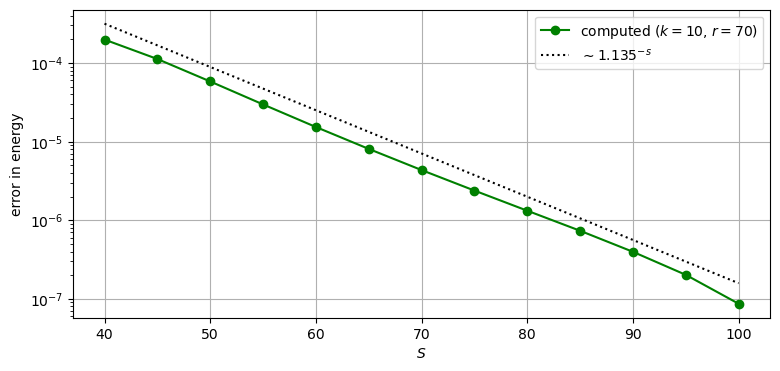

In [39]:
plt.figure(figsize=(9, 4))
plt.plot(ss, [abs(e - 1 / 6) for e in energies_s], "-o", color="green", label="computed ($k=10$, $r=70$)")
plt.plot(ss, [5e-2 * 1.135 ** (-s) for s in ss], ":", color="k", label=r"$\sim 1.135^{-s}$")
plt.xlabel("$S$")
plt.ylabel("error in energy")
plt.yscale("log")
plt.legend()
plt.grid()

In [20]:
energies_s

[Array(0.16646827, dtype=float64),
 Array(0.16655434, dtype=float64),
 Array(0.16660846, dtype=float64),
 Array(0.16663695, dtype=float64),
 Array(0.16665133, dtype=float64),
 Array(0.16665859, dtype=float64),
 Array(0.16666232, dtype=float64),
 Array(0.16666428, dtype=float64),
 Array(0.16666534, dtype=float64),
 Array(0.16666593, dtype=float64),
 Array(0.16666627, dtype=float64),
 Array(0.16666646, dtype=float64),
 Array(0.16666658, dtype=float64)]

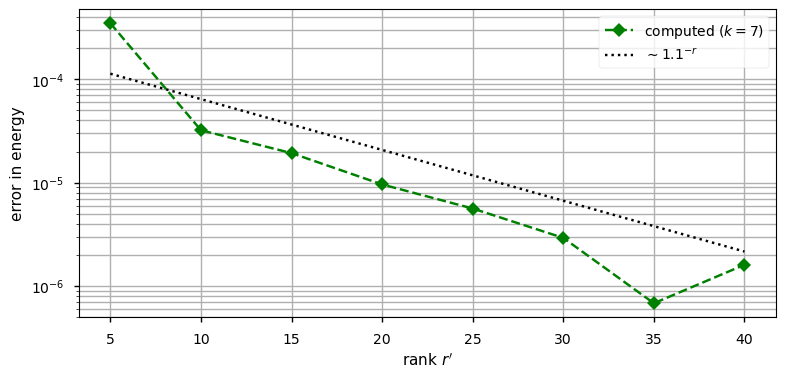

In [ ]:
rs = [5, 10, 15, 20, 25, 30, 35, 40]
_energies = energies_uniform[7]
with style.context("seaborn-v0_8-notebook"):
    plt.figure(figsize=(9, 4))
    plt.plot(rs, [jnp.abs(e - 1 / 6) for e in _energies.values()], "--D", color="green", label="computed ($k=7$)")
    plt.plot(rs, [2e-4 * 1.12 ** (-_r) for _r in rs], ":", color="k", label=r"$\sim 1.12^{-r}$")
    plt.xlabel("rank $r'$")
    plt.ylabel("error in energy")
    plt.yscale("log")
    plt.grid(axis="x")
    plt.grid(axis="y", which="both")
    plt.legend()
    
plt.show()

## Energy for flower and vortex state

The same energy computation with the same setup is done for a flower and vortex state in the unit cube.

### Flower state:

In [ ]:


energies_flower = defaultdict(dict)
# flower state
for k in [4, 5, 6, 7, 8, 9]:
    for r in [10, 20, 30, 40, 50, 60]:
        grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, r)] * 3)
        model = BSpline(grid, degree=k - 1)
        solver = setup(model, target_tg)
        mag = fit_mag(solver, flower_state)  # prefit magnetization to functional Tucker format
        e = solve(solver, mag).block_until_ready()
        energies_flower[k][r] = e
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")

k=4, r=10, energy=1.481191e-01, fitting_time=6.798 ms
k=4, r=20, energy=1.515183e-01, fitting_time=7.850 ms
k=4, r=30, energy=1.522412e-01, fitting_time=9.463 ms
k=4, r=40, energy=1.525067e-01, fitting_time=16.422 ms
k=4, r=50, energy=1.526168e-01, fitting_time=24.619 ms
k=4, r=60, energy=1.526925e-01, fitting_time=30.772 ms
k=5, r=10, energy=1.530675e-01, fitting_time=6.780 ms
k=5, r=20, energy=1.530601e-01, fitting_time=8.241 ms
k=5, r=30, energy=1.529580e-01, fitting_time=11.176 ms
k=5, r=40, energy=1.529051e-01, fitting_time=17.349 ms
k=5, r=50, energy=1.528747e-01, fitting_time=22.310 ms
k=5, r=60, energy=1.528548e-01, fitting_time=33.581 ms
k=6, r=10, energy=1.530650e-01, fitting_time=6.739 ms
k=6, r=20, energy=1.528629e-01, fitting_time=8.111 ms
k=6, r=30, energy=1.528277e-01, fitting_time=11.272 ms
k=6, r=40, energy=1.528145e-01, fitting_time=19.157 ms
k=6, r=50, energy=1.528067e-01, fitting_time=25.388 ms
k=6, r=60, energy=1.528002e-01, fitting_time=33.900 ms
k=7, r=10, energy

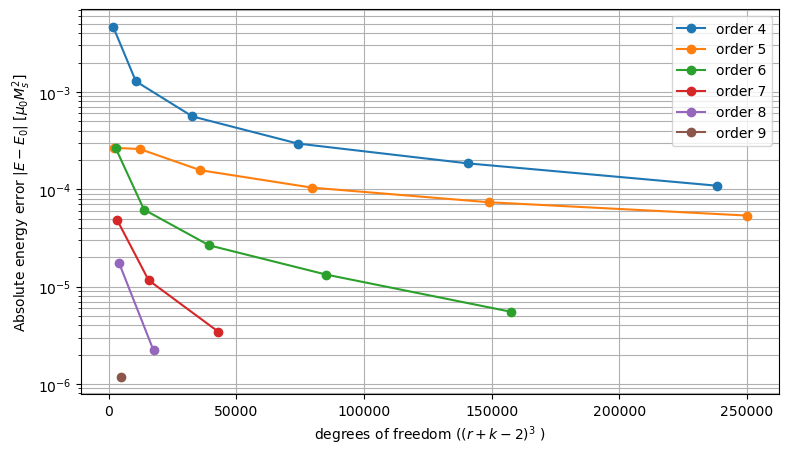

In [68]:
from scipy.optimize import curve_fit

def _model(h, Einf, C, p):
    return Einf + C * h**(-p)

rs = np.array(list(energies_flower[9].keys()))
es = np.array(list(energies_flower[9].values()))
p0 = [es[-1], 1e-2, -1.5]
params, cov = curve_fit(_model, rs, es, p0=p0, method='lm')
Einf, C, p = params
# uncertainties:
perr = np.sqrt(np.diag(cov))

In [69]:
Einf, C, p, perr

(np.float64(0.15280118137528023),
 np.float64(-1.8301718055368798e-10),
 np.float64(-3.046829285811528),
 array([7.28525614e-07, 1.26711470e-10, 1.68289930e-01]))

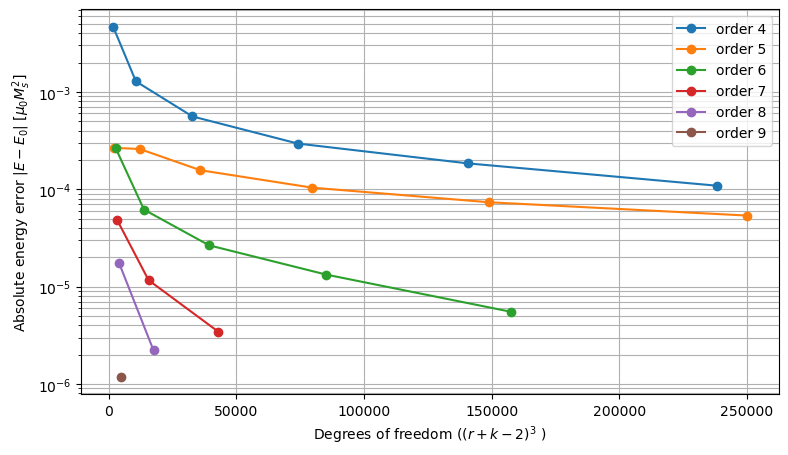

In [70]:
from itertools import takewhile
e_true = Einf  # extrapolated for k = 9
plt.figure(figsize=(9, 5))

for k in [4, 5, 6, 7, 8, 9]:
    try:
        r, e = zip(*list(energies_flower[k].items()))
    except:
        pass
    
    i = np.argmax(jnp.abs(np.array(e) - e_true) < 1e-5)
    if np.all(np.abs(np.array(e) - e_true) > 1e-5):
        i = len(e)
    #i = np.clip(i, 1, len(e) - 1) + 1
    i = i + 1
    plt.plot([(_r + k - 2)**3 for _r in r[:i]], [abs(_e - e_true) for _e in e[:i]], "-o", label = f"order {k}")
    
plt.yscale("log")
plt.grid(which="both")
plt.xlabel(r"Degrees of freedom ($(r + k - 2)^3$ )")
plt.ylabel(r"Absolute energy error $|E - E_0|$ $[\mu_0 M_s^2]$")
plt.legend()
plt.show()

### Vortex state:

In [ ]:
energies_vortex = defaultdict(dict)

# vortex state
for k in [4, 5, 6, 7, 8, 9]:
    for r in [10, 20, 30, 40, 50, 60, 70, 80]:
        grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, r)] * 3)
        model = BSpline(grid, degree=k - 1)
        solver = setup(model, target_tg)
        mag = fit_mag(solver, vortex_state)  # prefit magnetization to functional Tucker format
        e = solve(solver, mag).block_until_ready()
        energies_vortex[k][r] = e
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")

k=4, r=10, energy=1.839140e-02, fitting_time=13.520 ms
k=4, r=20, energy=2.083909e-02, fitting_time=20.609 ms
k=4, r=30, energy=2.134449e-02, fitting_time=30.545 ms
k=4, r=40, energy=2.153675e-02, fitting_time=69.733 ms
k=4, r=50, energy=2.163001e-02, fitting_time=107.246 ms
k=4, r=60, energy=2.168215e-02, fitting_time=174.848 ms
k=4, r=70, energy=2.171414e-02, fitting_time=412.651 ms
k=4, r=80, energy=2.173513e-02, fitting_time=664.927 ms
k=5, r=10, energy=2.138978e-02, fitting_time=13.622 ms
k=5, r=20, energy=2.189366e-02, fitting_time=20.386 ms
k=5, r=30, energy=2.187466e-02, fitting_time=37.287 ms
k=5, r=40, energy=2.185373e-02, fitting_time=67.782 ms
k=5, r=50, energy=2.183952e-02, fitting_time=108.503 ms
k=5, r=60, energy=2.182993e-02, fitting_time=179.229 ms
k=5, r=70, energy=2.182323e-02, fitting_time=586.573 ms
k=5, r=80, energy=2.181837e-02, fitting_time=836.126 ms
k=6, r=10, energy=2.331356e-02, fitting_time=17.182 ms
k=6, r=20, energy=2.184117e-02, fitting_time=26.448 ms
k=

2025-11-07 15:12:00.335164: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.61GiB (rounded to 6019645952)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-11-07 15:12:00.336892: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ***___________________________________________________*_____*_______________________________________
E1107 15:12:00.336929   32809 pjrt_stream_executor_client.cc:2916] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6019645944 bytes. [tf-allocator-allocation-error='']


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6019645944 bytes.

## Vortex state in a thin film

For other domains, such as a thin film $[-0.5, 0.5]\times [-0.5, 0.5] \times [-0.05, 0.05]$ we need to adjust the spline model and the quadrature tensor grid. As a reference we have $e_d=0.001562$ computed by *mumax3*.

In [ ]:
# thin film
energies_thin_film = defaultdict(dict)

target_tg = TensorGrid(
    jnp.array([-0.5, 0.5]),
    jnp.array([-0.5, 0.5]),
    jnp.array([-0.05, 0.05]),
).to_gauss((250, 250, 50))


for k in [4, 5, 6, 7, 8]:
    for r in [20, 40, 60]:
        grid = TensorGrid(
            jnp.linspace(-0.5, 0.5, r),
            jnp.linspace(-0.5, 0.5, r),
            jnp.linspace(-0.05, 0.05, r // 4)
        )
        model = BSpline(grid, degree=k - 1)
        solver = setup(model, target_tg)
        mag = fit_mag(solver, vortex_state)  # prefit magnetization to functional Tucker format
        e = solve(solver, mag).block_until_ready()
        energies_thin_film[k][r] = e
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")

# Thin film with two layers

In this example we demonstrate the higher order stray field method for a thin film with two layers. The top layer $\Omega_1=[-0.4, 0.5][-0.5, 0.5][0, 0.05]$ has a uniform magnetization in the $[0.4, 1, 0.6]^T$ direction and the bottom layer $\Omega_2=[-0.5, 0.4][-0.5, 0.5][-0.05, 0]$ has a uniform magnetization in the $[-1, -0.3, 0.0]^T$ direction. Additionally, we use $Ms_1 = 1$ for $\Omega_1$ and $Ms_2=2$ for $\Omega_2$.

In [61]:
r = 40
k = 8

unit_vec = lambda x: x / jnp.linalg.norm(x, keepdims=True)
m1 = lambda x: unit_vec(jnp.array([0.4, 1, 0.6]))
m2 = lambda x: unit_vec(jnp.array([-1, -0.3, 0.0])) * 2

magnetization = {
    0: m1,
    1: m2,
}


grid1 = TensorGrid(
    jnp.linspace(-0.4, 0.5, r),
    jnp.linspace(-0.5, 0.5, r),
    jnp.linspace(0.0, 0.05, r // 4),
)
grid2 = TensorGrid(
    jnp.linspace(-0.5, 0.4, r),
    jnp.linspace(-0.5, 0.5, r),
    jnp.linspace(-0.05, 0.0, r // 4),
)

targets = {
    0: TensorGrid(
        jnp.linspace(-0.4, 0.5, 2),
        jnp.linspace(-0.5, 0.5, 2),
        jnp.linspace(0.0, 0.05, 2),
    ).to_gauss((250, 250, 50)),
    1: TensorGrid(
        jnp.linspace(-0.5, 0.4, 2),
        jnp.linspace(-0.5, 0.5, 2),
        jnp.linspace(-0.05, 0.0, 2),
    ).to_gauss((250, 250, 50))
}

models = {
    0: BSpline(grid1, degree=k - 1),
    1: BSpline(grid2, degree=k - 1),
}

solver = setup(models, targets, s=70)
mag = fit_mag(solver, magnetization)  # prefit magnetization to functional Tucker format
e = solve(solver, mag).block_until_ready()

In [62]:
e

Array(0.0108569, dtype=float64)